# Ward 1: Pedestrian and Cyclist Crash Data

In [20]:
import geopandas as gpd
import numpy as np
import pandas as pd

from sodapy import Socrata
from shapely.wkt import loads
from shapely.geometry import MultiPolygon, Point

## Read in data from the Chicago data portal

Traffic Crashes: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data

Traffic Crashes - People: https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data

Ward Maps: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Wards-2023-Map/cdf7-bgn3

You need to download a csv file to get the ward boundaries

In [21]:
# Establish connection with Chicago data portal
client = Socrata("data.cityofchicago.org", None)

In [53]:
# Get crash data

# Increase timeout counter because this takes a while
client.timeout = 300 # seconds

# Earliest date of crash data
start_date = '2024-01-01'

# Read in crashes
crash_df = pd.DataFrame.from_records(client.get("85ca-t3if", 
    where=f"crash_date > '{start_date}'",                                          
    limit=100000))
print(crash_df['crash_date'].min())

2024-01-01T00:01:00.000


In [54]:
# Get crashes people data for pedestrians and cyclists
crash_people_df = pd.DataFrame.from_records(client.get("u6pd-qa9d", 
    where=f"crash_date > '{start_date}' and (person_type = 'PEDESTRIAN' or person_type='BICYCLE')",                                          
    limit=100000))
print(crash_people_df['crash_date'].min())

2024-01-01T00:28:00.000


In [55]:
# Merge the datasets on crash_id
crash_df = pd.merge(crash_df, crash_people_df, on='crash_record_id', 
    how='inner', suffixes=('_crash', '_people'))
crash_df

,crash_record_id,crash_date_crash,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,driver_action,driver_vision,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,hospital,ejection,bac_result_value
0,7b5c36886d32e01ca392f519d62651e18c88867d2ea98d...,2024-11-19T19:53:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,OTHER,NOT OBSCURED,NORMAL,CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NaN,NaN,NaN
1,6ba637cb43b65f5fb0233b4787d452af88bed6f9c85e2f...,2024-11-19T17:10:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,FOUR WAY,STRAIGHT AND LEVEL,...,FAILED TO YIELD,NOT OBSCURED,NORMAL,CROSSING - AGAINST SIGNAL,NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,NaN,NaN
2,6ba637cb43b65f5fb0233b4787d452af88bed6f9c85e2f...,2024-11-19T17:10:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,FOUR WAY,STRAIGHT AND LEVEL,...,FAILED TO YIELD,NOT OBSCURED,NORMAL,CROSSING - AGAINST SIGNAL,NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,NaN,NaN
3,c0d2448e2ab4076f798c67c57895a0f78b038c49abcdfa...,2024-11-19T17:10:00.000,25,UNKNOWN,UNKNOWN,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,NONE,UNKNOWN,UNKNOWN,CROSSING - NO CONTROLS (AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,COMMUNITY FIRST,NaN,NaN
4,985cf35467d61381135dabfcf305c3678ec3c7a90285c5...,2024-11-19T16:58:00.000,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,UNKNOWN,NOT OBSCURED,NORMAL,WITH TRAFFIC,NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,ST BERNARDS HOSPITAL,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5171,0e8c27021d97eab1bda3a29e80c79f24b2d6fb5e50d1a4...,2024-01-01T17:44:00.000,25,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,UNKNOWN,UNKNOWN,NORMAL,WITH TRAFFIC,NO CONTRASTING CLOTHING,IN ROADWAY,"TEST PERFORMED, RESULTS UNKNOWN",NaN,TOTALLY EJECTED,NaN
5172,de578a34bf570d06afe618dd7eccaa3d21647294e625d2...,2024-01-01T09:45:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,FAILED TO YIELD,UNKNOWN,UNKNOWN,CROSSING - AGAINST SIGNAL,NO CONTRASTING CLOTHING,NOT IN ROADWAY,NaN,NaN,NaN,NaN
5173,8ddc89d744d49b801f9b7bd37309e20ed7480a14bf8ec2...,2024-01-01T02:40:00.000,30,NO CONTROLS,NO CONTROLS,SNOW,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,NONE,NaN,NaN,NOT AT INTERSECTION,NO CONTRASTING CLOTHING,NOT IN ROADWAY,TEST NOT OFFERED,ADVOCATE CHRIST MEDICAL CENTER,NaN,NaN
5174,aa3ca065ad36f899268585f97694c14966cd48653104c6...,2024-01-01T00:45:00.000,20,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DARKNESS,PEDESTRIAN,FOUR WAY,STRAIGHT AND LEVEL,...,NONE,NOT OBSCURED,NORMAL,CROSSING - CONTROLS PRESENT (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,COMMUNITY,NaN,NaN


## Limit data to crashes within Ward 1

In [56]:
# Read in the ward boundaries
ward_boundaries = pd.read_csv('Boundaries_-_Wards__2023-__20241119.csv')
ward_boundaries.head(5)

,Ward,the_geom,objectid,edit_date,ward_id,globalid,st_area_sh,st_length_
0,1,MULTIPOLYGON (((-87.68777205374418 41.92858465...,51,06/01/2022,1,{DB2A2A7D-FAF1-42A4-B061-AE18C31A80BB},6.589346e+07,61878.821587
1,2,MULTIPOLYGON (((-87.62517201063106 41.90399836...,52,06/01/2022,2,{88F300F6-D6DF-4337-8DE3-0C2D27A5B338},3.128511e+07,74175.949239
2,5,MULTIPOLYGON (((-87.56030308695986 41.76635735...,55,06/01/2022,5,{0A109A41-9DED-47D7-934E-1EA1CC7EE025},1.120803e+08,88207.690241
3,6,MULTIPOLYGON (((-87.61794321281114 41.77292489...,56,06/01/2022,6,{FD74A999-4BBA-4CE3-BEBB-CC76423037E8},1.392022e+08,80779.851890
4,7,MULTIPOLYGON (((-87.54393108740227 41.76029599...,57,06/01/2022,7,{279FCBD9-EA0D-4FFC-A8CA-EDA2676C0721},1.414924e+08,98906.567862


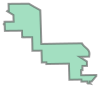

In [64]:
# Get the Ward 1 boundaries
ward1 = loads(ward_boundaries.loc[ward_boundaries['Ward'] == 1, 'the_geom'].iloc[0])
ward1


In [65]:
# Determine if a latitude and longitude are within the ward
crash_df_geo = gpd.GeoDataFrame(crash_df, 
    geometry=gpd.points_from_xy(crash_df['longitude'], crash_df['latitude']), 
    crs="EPSG:4326"
)
crash_df_geo['in_ward1'] = crash_df_geo.geometry.apply(lambda x: ward1.contains(x))

crash_df_geo['in_ward1'].value_counts()


/Users/eachase/miniconda3/envs/py312/lib/python3.12/site-packages/shapely/predicates.py:526: RuntimeWarning: invalid value encountered in contains
  return lib.contains(a, b, **kwargs)


in_ward1
False    5000
True      176
Name: count, dtype: int64

In [66]:
# Limit dataframe to crashes within the ward
ward1_crashes = crash_df_geo[crash_df_geo['in_ward1']]
ward1_crashes


,crash_record_id,crash_date_crash,posted_speed_limit,traffic_control_device,device_condition,weather_condition,lighting_condition,first_crash_type,trafficway_type,alignment,...,physical_condition,pedpedal_action,pedpedal_visibility,pedpedal_location,bac_result,hospital,ejection,bac_result_value,geometry,in_ward1
37,8cb811c13668d2a4b6ed9f595dbcd2d82f256a03de4ae8...,2024-11-16T20:00:00.000,23,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,NORMAL,WITH TRAFFIC,OTHER LIGHT SOURCE USED,BIKE LANE,TEST NOT OFFERED,NaN,UNKNOWN,NaN,POINT (-87.70217 41.92488),True
56,a31cbc66a69ad127359e6c5f9e1cc0dbdb7ce6bca99fe4...,2024-11-14T20:28:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,RAIN,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,NORMAL,UNKNOWN/NA,NO CONTRASTING CLOTHING,UNKNOWN/NA,TEST NOT OFFERED,ST. MARY'S,NaN,NaN,POINT (-87.66653 41.90325),True
100,b54fd2c3cb7117bf9bcd0d67a712eafc5638dd71dfdd39...,2024-11-11T16:00:00.000,30,OTHER,OTHER,CLEAR,DAYLIGHT,PEDALCYCLIST,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,...,NORMAL,WITH TRAFFIC,OTHER LIGHT SOURCE USED,BIKE LANE,NaN,NaN,TOTALLY EJECTED,NaN,POINT (-87.67755 41.90829),True
106,42139cf8932a7e6fe7896aa6b22f3af71f486fbdc60949...,2024-11-11T07:30:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,NOT DIVIDED,STRAIGHT AND LEVEL,...,NORMAL,STANDING IN ROADWAY,NO CONTRASTING CLOTHING,IN ROADWAY,TEST NOT OFFERED,NaN,NaN,NaN,POINT (-87.67730 41.89959),True
114,92c494d07db7cf4e7ceaa1f411419f7d84097f73264a92...,2024-11-10T03:58:00.000,30,NO CONTROLS,NO CONTROLS,RAIN,"DARKNESS, LIGHTED ROAD",PEDESTRIAN,DIVIDED - W/MEDIAN BARRIER,STRAIGHT AND LEVEL,...,REMOVED BY EMS,UNKNOWN/NA,NO CONTRASTING CLOTHING,BIKE LANE,TEST NOT OFFERED,STROGER HOSPITAL,NaN,NaN,POINT (-87.66767 41.90433),True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5028,83dc570b6336506da4f37991680951b3901e25be89a724...,2024-01-16T14:00:00.000,25,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,NORMAL,CROSSING - WITH SIGNAL,NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,ASCENSION HEALTH,NaN,NaN,POINT (-87.68207 41.90589),True
5043,571b244942aa1a5744136c602cd8ab9a9f848c3a0076c5...,2024-01-13T16:51:00.000,35,UNKNOWN,UNKNOWN,BLOWING SNOW,DUSK,PEDESTRIAN,FOUR WAY,STRAIGHT AND LEVEL,...,NORMAL,UNKNOWN/NA,NO CONTRASTING CLOTHING,UNKNOWN/NA,TEST NOT OFFERED,STROGER,NaN,NaN,POINT (-87.66764 41.90338),True
5057,3361fd332bbf670b8c9fb8679b5ee92ce79c39d60188d7...,2024-01-11T13:00:00.000,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,PEDALCYCLIST,NOT DIVIDED,STRAIGHT AND LEVEL,...,NaN,TURNING LEFT,NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,NONE,NaN,POINT (-87.68742 41.91241),True
5126,99a65da65c316d2ce9449aafc45ad8480440738978b7d4...,2024-01-06T20:16:00.000,30,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,SNOW,DARKNESS,PEDESTRIAN,NOT DIVIDED,STRAIGHT AND LEVEL,...,UNKNOWN,CROSSING - NO CONTROLS (NOT AT INTERSECTION),NO CONTRASTING CLOTHING,IN CROSSWALK,TEST NOT OFFERED,NaN,NaN,NaN,POINT (-87.68855 41.91223),True


# Export data
Clean a bit before exporting

In [67]:
ward1_crashes.columns

Index(['crash_record_id', 'crash_date_crash', 'posted_speed_limit',
       'traffic_control_device', 'device_condition', 'weather_condition',
       'lighting_condition', 'first_crash_type', 'trafficway_type',
       'alignment', 'roadway_surface_cond', 'road_defect', 'report_type',
       'crash_type', 'intersection_related_i', 'damage',
       'date_police_notified', 'prim_contributory_cause',
       'sec_contributory_cause', 'street_no', 'street_direction',
       'street_name', 'beat_of_occurrence', 'num_units', 'most_severe_injury',
       'injuries_total', 'injuries_fatal', 'injuries_incapacitating',
       'injuries_non_incapacitating', 'injuries_reported_not_evident',
       'injuries_no_indication', 'injuries_unknown', 'crash_hour',
       'crash_day_of_week', 'crash_month', 'latitude', 'longitude', 'location',
       'hit_and_run_i', 'private_property_i', 'photos_taken_i',
       'statements_taken_i', 'crash_date_est_i', 'work_zone_i',
       'work_zone_type', 'workers_presen

In [68]:
# Decide which columns to export
df_export = ward1_crashes[[
    'crash_date_crash',
    'person_type', 
    'street_no',
    'street_direction',
    'street_name',
    'latitude',
    'longitude',
    'posted_speed_limit',
    'driver_action',    
    'injury_classification',
    'driver_vision',
    'pedpedal_action',
    'pedpedal_location',
    'first_crash_type',
]]

# Rename some columns
df_export = df_export.rename(columns={'crash_date_crash': 'crash_date_time'})

# Reset indices
df_export = df_export.reset_index(drop=True)
df_export

,crash_date_time,person_type,street_no,street_direction,street_name,latitude,longitude,posted_speed_limit,driver_action,injury_classification,driver_vision,pedpedal_action,pedpedal_location,first_crash_type
0,2024-11-16T20:00:00.000,BICYCLE,2403,N,SACRAMENTO AVE,41.924878729,-87.702174555,23,OTHER,NONINCAPACITATING INJURY,UNKNOWN,WITH TRAFFIC,BIKE LANE,PEDALCYCLIST
1,2024-11-14T20:28:00.000,PEDESTRIAN,1535,W,DIVISION ST,41.903248153,-87.666533812,30,UNKNOWN,NONINCAPACITATING INJURY,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,PEDESTRIAN
2,2024-11-11T16:00:00.000,BICYCLE,1500,N,DAMEN AVE,41.908287163,-87.677551122,30,NONE,NONINCAPACITATING INJURY,NOT OBSCURED,WITH TRAFFIC,BIKE LANE,PEDALCYCLIST
3,2024-11-11T07:30:00.000,PEDESTRIAN,1000,N,DAMEN AVE,41.899594831,-87.677303736,30,NONE,"REPORTED, NOT EVIDENT",NOT OBSCURED,STANDING IN ROADWAY,IN ROADWAY,REAR END
4,2024-11-10T03:58:00.000,PEDESTRIAN,1238,N,ASHLAND AVE,41.904327688,-87.667668594,30,NONE,INCAPACITATING INJURY,UNKNOWN,UNKNOWN/NA,BIKE LANE,PEDESTRIAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,2024-01-16T14:00:00.000,PEDESTRIAN,1333,N,LEAVITT ST,41.905885713,-87.682074775,25,NONE,NONINCAPACITATING INJURY,NOT OBSCURED,CROSSING - WITH SIGNAL,IN CROSSWALK,PEDESTRIAN
172,2024-01-13T16:51:00.000,PEDESTRIAN,1200,N,ASHLAND AVE,41.903377468,-87.667643142,35,NONE,NONINCAPACITATING INJURY,OTHER,UNKNOWN/NA,UNKNOWN/NA,PEDESTRIAN
173,2024-01-11T13:00:00.000,BICYCLE,1708,N,WESTERN AVE,41.912413393,-87.687421494,30,NONE,NONINCAPACITATING INJURY,NOT OBSCURED,TURNING LEFT,IN CROSSWALK,PEDALCYCLIST
174,2024-01-06T20:16:00.000,PEDESTRIAN,2430,W,WABANSIA AVE,41.91223274,-87.688545941,30,NONE,NONINCAPACITATING INJURY,UNKNOWN,CROSSING - NO CONTROLS (NOT AT INTERSECTION),IN CROSSWALK,PEDESTRIAN


In [69]:
# Export file
df_export.to_csv(f'ward1_crashes_since_{start_date}.csv', index=False)